# Initialization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_dir = ''
workdir = ''

In [3]:
seed = 42

# Loading files

In [4]:
#!unzip /kaggle/input/facial-keypoints-detection/training.zip
!unzip training.zip

Archive:  training.zip
  inflating: training.csv            


In [5]:
#!unzip /kaggle/input/facial-keypoints-detection/test.zip
!unzip test.zip

Archive:  test.zip
  inflating: test.csv                


# Data overview

In [6]:
id_lookup_table = pd.read_csv(input_dir + 'IdLookupTable.csv')

In [7]:
test = pd.read_csv(workdir + 'test.csv')
train = pd.read_csv(workdir + 'training.csv')

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

- training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
- submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict.

In [ ]:
train.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [ ]:
test.head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [ ]:
id_lookup_table.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [ ]:
len(id_lookup_table)

27124

In [ ]:
pd.read_csv(input_dir + 'SampleSubmission.csv')

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [ ]:
train.isnull().any()

,0
left_eye_center_x,True
left_eye_center_y,True
right_eye_center_x,True
right_eye_center_y,True
left_eye_inner_corner_x,True
left_eye_inner_corner_y,True
left_eye_outer_corner_x,True
left_eye_outer_corner_y,True
right_eye_inner_corner_x,True
right_eye_inner_corner_y,True


In [ ]:
pxls = train['Image'].iloc[0].split()
print(f"Pixels: {len(pxls)}")
print(f"Desired image size: {96*96}")

Pixels: 9216
Desired image size: 9216


In [ ]:
def get_image(str_image: str, size=96, color_channel=False):
    pixels = np.array([int(pixel) for pixel in str_image.split()])
    pixels = pixels.reshape(size, size, 1)
    return pixels

## Image examples

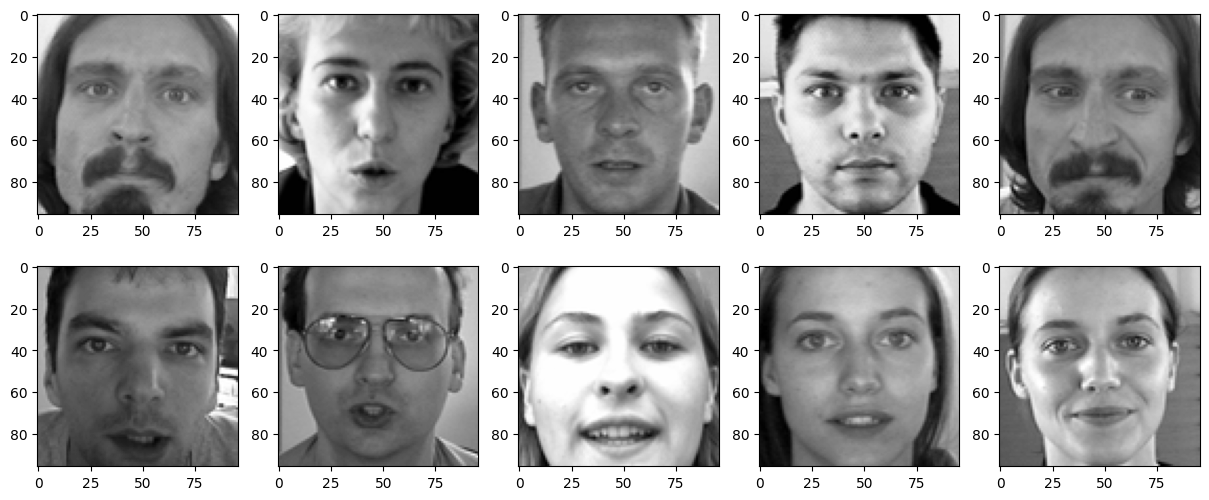

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for index, ax in enumerate(axs.flatten()):
    ax.imshow(get_image(train['Image'].iloc[index]), cmap='gray')

## Image examples with keypoints

In [ ]:
unique_keypoints = set([column[:-2] for column in train.drop('Image', axis=1).columns])
unique_keypoints

{'left_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'mouth_center_bottom_lip',
 'mouth_center_top_lip',
 'mouth_left_corner',
 'mouth_right_corner',
 'nose_tip',
 'right_eye_center',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end'}

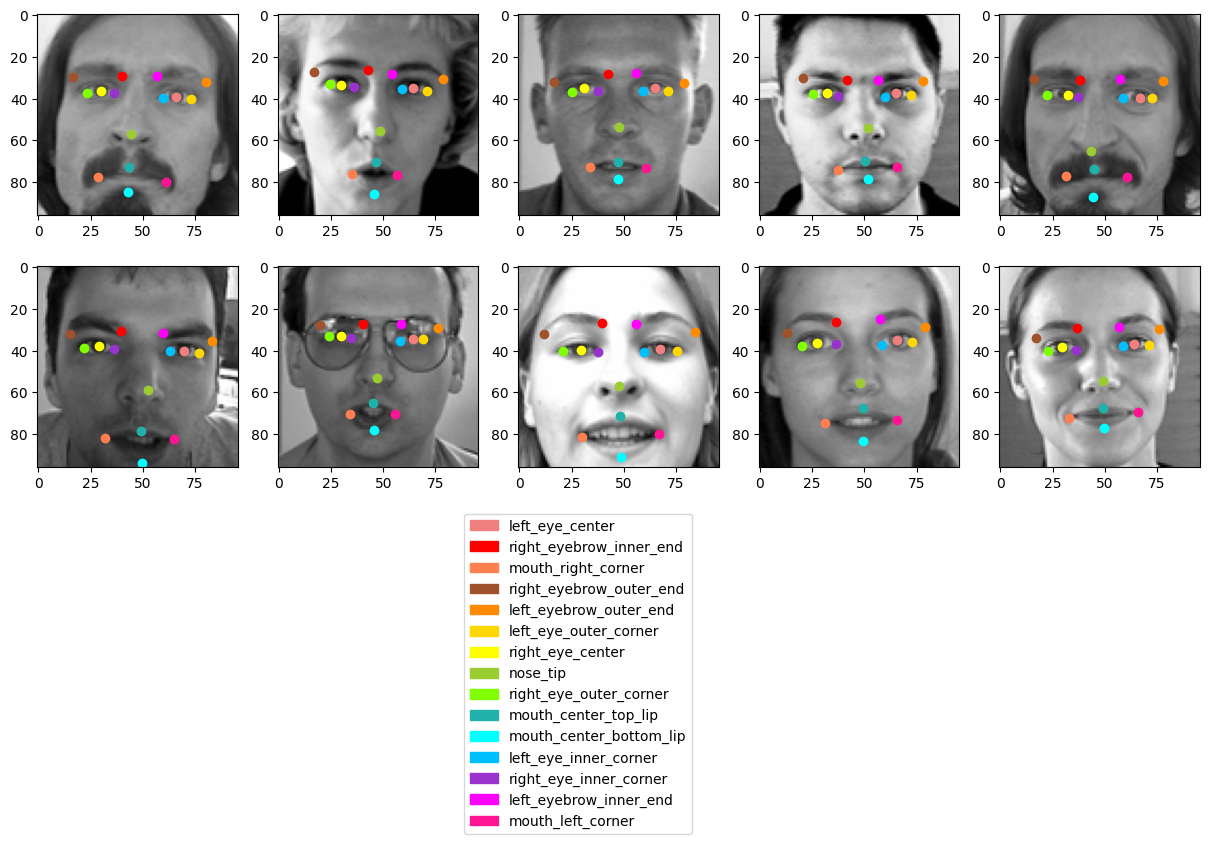

In [ ]:
colors = ['lightcoral', 'red', 'coral', 'sienna', 'darkorange', 'gold', 'yellow', 'yellowgreen',
          'chartreuse', 'lightseagreen', 'aqua', 'deepskyblue', 'darkorchid', 'fuchsia', 'deeppink']

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for index, ax in enumerate(axs.flatten()):
    ax.imshow(get_image(train['Image'].iloc[index]), cmap='gray')
    for key_id, unikey in enumerate(unique_keypoints):
        if not pd.isnull(train[unikey + '_x'].iloc[index]):
            x = [train[unikey + '_x'].iloc[index]]
            y = [train[unikey + '_y'].iloc[index]]
            ax.scatter(x, y, color=colors[key_id])

handles = []
for color, keypoint in zip(colors, list(unique_keypoints)):
    handles.append(mpatches.Patch(color=color, label=keypoint))
plt.legend(handles=handles, bbox_to_anchor = [-1.5, -0.2]);

# Dummy predictor

As a first step we can predict average coordinates for keypoints to compare score with our future models.

In [ ]:
dummy_predictor = dict(zip(train.drop('Image', axis=1).columns, np.nanmean(train.drop('Image', axis=1), axis=0)))
dummy_predictor

{'left_eye_center_x': 66.35902124475365,
 'left_eye_center_y': 37.65123419193395,
 'right_eye_center_x': 30.306101514079753,
 'right_eye_center_y': 37.97694257172698,
 'left_eye_inner_corner_x': 59.15933943740387,
 'left_eye_inner_corner_y': 37.94475232796772,
 'left_eye_outer_corner_x': 73.3304779831461,
 'left_eye_outer_corner_y': 37.707008310792986,
 'right_eye_inner_corner_x': 36.65260694805725,
 'right_eye_inner_corner_y': 37.98990191451049,
 'right_eye_outer_corner_x': 22.384504479169355,
 'right_eye_outer_corner_y': 38.03349517525053,
 'left_eyebrow_inner_end_x': 56.06851307930929,
 'left_eyebrow_inner_end_y': 29.332678249311716,
 'left_eyebrow_outer_end_x': 79.48282586419953,
 'left_eyebrow_outer_end_y': 29.734860732432317,
 'right_eyebrow_inner_end_x': 39.32213692201747,
 'right_eyebrow_inner_end_y': 29.502998474112996,
 'right_eyebrow_outer_end_x': 15.871177472719152,
 'right_eyebrow_outer_end_y': 30.428165911873432,
 'nose_tip_x': 48.37418629032876,
 'nose_tip_y': 62.7158835

In [ ]:
predictions = id_lookup_table.copy()
predictions['Location'] = predictions['FeatureName'].apply(lambda x: float(dummy_predictor[x]))
predictions.drop(['ImageId', 'FeatureName'], axis=1).to_csv(workdir + 'dummy_submission.csv', index=False)

### Results:

| Score | Private Score |
|-------|---------------|
|3.96243|3.78006        |

# Modelling notes

## 1. Output file
There are 1783 images in test set. Submission file has to have 27124 rows. So the points that are not exist in test images must be not included in submission file. Also these points should be ignored while local model evaluation. In `IdLookupTable` file all the keypoints we need are presented, so it's not necessary to predict the existance of keypoints. We can just set all NaNs to special value.

## 2. Existance prediction
In this particular case our goal is not to build the real model for keypoints detection but only predict defined points position. So the loss function can use masks for points are not specified on image. And just to fill gaps we can use special value like -1. I think it is good strategy in this case cause we are interested in better score rather than correct prediction.

If I was building a model for real-life problem, I would use additional output neurons to predict probability of keypoint existance. But now we just don't need it.

In [8]:
class FKDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame, transform=None):
        self.images, self.keypoints = self.preprocess_data(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        imgs = self.get_image(self.images.to_numpy()[idx])
        kpts = self.keypoints.to_numpy()[idx]
        sample = {'img': imgs, 'kpts': kpts}
        if self.transform:
            sample = self.transform(sample)
        else:
            sample = self.basic_transform(sample)
        return sample

    def preprocess_data(self, dataset):
        images = dataset['Image']
        keypoints = dataset.drop('Image', axis=1)
        keypoints.fillna(-1, inplace=True)
        return images, keypoints

    def get_image(self, str_image: str, size=96):
        pixels = np.array([int(pixel) for pixel in str_image.split()])
        pixels = pixels.reshape(1, size, size)
        return pixels

    def basic_transform(self, sample: dict):
        sample['img'] = torch.FloatTensor(sample['img']).repeat(3, 1, 1) / 255.
        sample['kpts'] = torch.FloatTensor(sample['kpts']) / 96.
        return sample

In [9]:
ds = FKDataset(train)
sample = ds.__getitem__(0)
sample

{'img': tensor([[[0.9333, 0.9255, 0.9294,  ..., 0.9804, 0.9804, 0.9804],
          [0.9216, 0.9333, 0.9255,  ..., 0.9765, 0.9804, 0.9843],
          [0.9294, 0.9255, 0.9294,  ..., 0.9843, 0.9843, 0.9804],
          ...,
          [0.7294, 0.7176, 0.7098,  ..., 0.2039, 0.2235, 0.2353],
          [0.7412, 0.7373, 0.8118,  ..., 0.2392, 0.2706, 0.3059],
          [0.7490, 0.7216, 0.7216,  ..., 0.2745, 0.2941, 0.3529]],
 
         [[0.9333, 0.9255, 0.9294,  ..., 0.9804, 0.9804, 0.9804],
          [0.9216, 0.9333, 0.9255,  ..., 0.9765, 0.9804, 0.9843],
          [0.9294, 0.9255, 0.9294,  ..., 0.9843, 0.9843, 0.9804],
          ...,
          [0.7294, 0.7176, 0.7098,  ..., 0.2039, 0.2235, 0.2353],
          [0.7412, 0.7373, 0.8118,  ..., 0.2392, 0.2706, 0.3059],
          [0.7490, 0.7216, 0.7216,  ..., 0.2745, 0.2941, 0.3529]],
 
         [[0.9333, 0.9255, 0.9294,  ..., 0.9804, 0.9804, 0.9804],
          [0.9216, 0.9333, 0.9255,  ..., 0.9765, 0.9804, 0.9843],
          [0.9294, 0.9255, 0.9294

In [10]:
def visualize_sample(sample: dict):
    image = torch.permute(sample['img'], (1, 2, 0)).cpu().numpy()
    plt.imshow(image.astype(np.uint8))
    keypoints = sample['kpts'].view(-1, 2).cpu().numpy()
    plt.scatter(keypoints[:, 0], keypoints[:, 1])

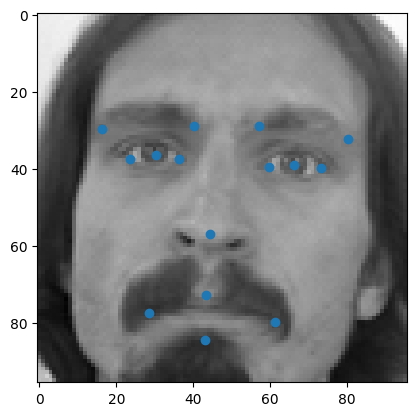

In [11]:
sample['img'] = sample['img'] * 255.
sample['kpts'] = sample['kpts'] * 96.
visualize_sample(sample)

# Modeling

As a model we will use ResNet18.

In [12]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

First layer is convolutional and pre-last layer is adaptive average pooling layer, so we don't need to resize images before passing it to the model. Last `fc` layer needs to be replaced with another layer with in_features=2048 and out_features=30.

In [75]:
for param in model.parameters():
    param.requires_grad = False

In [79]:
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 30),
    nn.Sigmoid()
)

In [76]:
for layer in model.fc:
    for parameter in layer.parameters():
        parameter.requires_grad = True

# Training

In [14]:
def train_model(model, criterion, optimizer, epochs,
                train_dataloader, val_dataloader,
                scheduler=None, output_info=False,
                device='cpu', chkpt_dir='models/', best_val_loss=1e3):
    train_losses = []
    val_losses = []
    lrs = []

    for epoch in range(epochs):
        running_train_loss = 0
        running_val_loss = 0

        # train step
        model.train()
        pbar = tqdm(train_dataloader)
        for batch in pbar:
            # getting items
            images, keypoints = batch['img'], batch['kpts']
            images = images.to(device)
            keypoints = keypoints.to(device)
            # forward
            out = model(images)
            loss = criterion(out, keypoints)
            # optimizing
            model.zero_grad()
            loss.backward()
            optimizer.step()
            # loss computing
            running_train_loss += loss.item()*keypoints.size()[0]

        epoch_train_loss = running_train_loss / len(train_dataloader.sampler)
        train_losses.append(epoch_train_loss)

        # validation step
        model.eval()
        with torch.no_grad():
            pbar = tqdm(val_dataloader)
            for batch in pbar:
                # getting items
                images, keypoints = batch['img'], batch['kpts']
                images = images.to(device)
                keypoints = keypoints.to(device)
                # forward
                out = model(images)
                loss = criterion(out, keypoints)
                # loss computing
                running_val_loss += loss.item()*keypoints.size()[0]

        epoch_val_loss = running_val_loss / len(val_dataloader.sampler)
        val_losses.append(epoch_val_loss)

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch}: train_loss={epoch_train_loss}, val_loss={epoch_val_loss}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), chkpt_dir + f'model.pt')
            if output_info:
                print(f"[INFO]: Model was saved with validation loss: {best_val_loss}")

        if output_info:
            if scheduler:
              last_lr = scheduler.get_last_lr()
              lrs.append(last_lr)
              print(f"[INFO]: LR={last_lr}")

    print("Done!")
    return train_losses, val_losses, lrs, best_val_loss

In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        yhat, y = self.filter_keypoints(yhat, y)
        return torch.sqrt(self.mse(yhat,y))

    def filter_keypoints(self, yhat, y):
        mask = torch.where(y < 0, False, True)
        yhat = yhat * 96.
        y = y * 96.
        return yhat[mask], y[mask]

In [16]:
test_loss = RMSELoss()
y_hat = torch.FloatTensor([5/96., 6/96., 0, 3])
y = torch.FloatTensor([4/96., 7/96., -1, -1])
expectation = torch.tensor(1.)
result = test_loss(y_hat, y)
print("Expectation: ", expectation)
print("Result: ", result)

Expectation:  tensor(1.)
Result:  tensor(1.)


In [17]:
val_size = 0.1
data_length = len(train)
split_point = int(data_length*(1 - val_size))

train_shuffled = train.sample(frac=1, random_state=seed)
train_data = train_shuffled.iloc[:split_point]
val_data = train_shuffled.iloc[split_point:]

In [18]:
train_dataset = FKDataset(train_data)
val_dataset = FKDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
#!mkdir /kaggle/working/models

In [19]:
def print_losses(train_losses, val_losses, lrs=[]):
    fig = plt.figure()
    x = range(len(train_losses))

    if lrs != []:
        fig = plt.figure(figsize=(10, 5))
        plt.subplot(122)
        plt.plot(x, lrs)
        plt.title('Learning rate')
        plt.subplot(121)

    plt.plot(x, train_losses, label='Train loss')
    plt.plot(x, val_losses, label='Validation loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

In [77]:
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
best_loss = 2.4905
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chkpt_dir = workdir + 'models/'

100%|██████████| 12/12 [00:02<00:00,  4.37it/s]


Epoch 0: train_loss=6.9128194667051295, val_loss=6.65753739099976
[INFO]: Model was saved with validation loss: 6.65753739099976
[INFO]: LR=[0.01]


100%|██████████| 12/12 [00:01<00:00,  6.66it/s]


Epoch 1: train_loss=5.524134276343173, val_loss=5.4438109343779
[INFO]: Model was saved with validation loss: 5.4438109343779
[INFO]: LR=[0.01]


100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


Epoch 2: train_loss=4.866303703072393, val_loss=4.2945155306065335
[INFO]: Model was saved with validation loss: 4.2945155306065335
[INFO]: LR=[0.01]


100%|██████████| 12/12 [00:01<00:00,  6.60it/s]


Epoch 3: train_loss=4.030934796808347, val_loss=3.733168994281309
[INFO]: Model was saved with validation loss: 3.733168994281309
[INFO]: LR=[0.01]


100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


Epoch 4: train_loss=3.8448035692958182, val_loss=3.662500725063026
[INFO]: Model was saved with validation loss: 3.662500725063026
[INFO]: LR=[0.001]


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch 5: train_loss=3.7138116783632755, val_loss=3.5212082325144016
[INFO]: Model was saved with validation loss: 3.5212082325144016
[INFO]: LR=[0.001]


100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Epoch 6: train_loss=3.6988767624502676, val_loss=3.5338628295465564
[INFO]: LR=[0.001]


100%|██████████| 12/12 [00:02<00:00,  5.73it/s]


Epoch 7: train_loss=3.678513537439392, val_loss=3.520252797282334
[INFO]: Model was saved with validation loss: 3.520252797282334
[INFO]: LR=[0.001]


100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


Epoch 8: train_loss=3.6882990991031988, val_loss=3.5252490486659056
[INFO]: LR=[0.001]


100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


Epoch 9: train_loss=3.681824990208783, val_loss=3.5343840791824017
[INFO]: LR=[0.0001]


100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Epoch 10: train_loss=3.6557409940722008, val_loss=3.4752467385420562
[INFO]: Model was saved with validation loss: 3.4752467385420562
[INFO]: LR=[0.0001]


100%|██████████| 12/12 [00:01<00:00,  6.47it/s]

Epoch 11: train_loss=3.6587267039252107, val_loss=3.537633339225823
[INFO]: LR=[0.0001]
Done!


<Figure size 640x480 with 0 Axes>

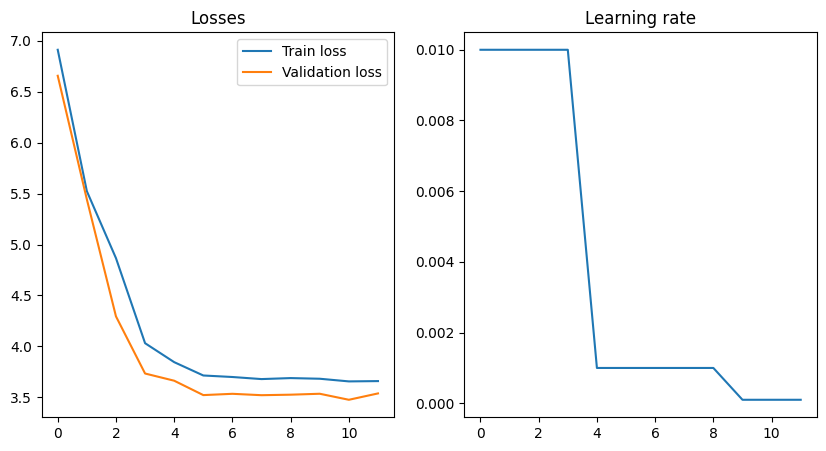

In [ ]:
model.to(device)
train_losses, val_losses, lrs, best_loss = train_model(
    model,
    criterion,
    optimizer,
    epochs,
    train_dataloader,
    val_dataloader,
    scheduler=scheduler,
    output_info=True,
    device=device,
    chkpt_dir=chkpt_dir,
    best_val_loss=best_loss
)
print_losses(train_losses, val_losses, lrs)

In [47]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# This cell was used for fine-tuning some times for 5 epochs with different learning rates

model.load_state_dict(torch.load(chkpt_dir + 'model.pt'))

criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
epochs = 5

model.to(device)
train_losses, val_losses, lrs, best_loss = train_model(
    model,
    criterion,
    optimizer,
    epochs,
    train_dataloader,
    val_dataloader,
    output_info=True,
    device=device,
    chkpt_dir=chkpt_dir,
    best_val_loss=best_loss
)
print_losses(train_losses, val_losses, lrs)

In [ ]:
from google.colab import files
files.download('models/model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
best_loss

2.4363142157277315

In [80]:
model.load_state_dict(torch.load(chkpt_dir + 'model.pt'))

<All keys matched successfully>

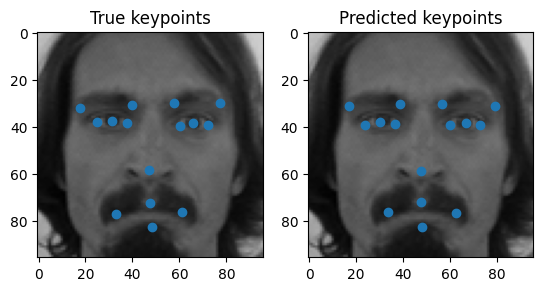

In [85]:
sample = val_dataset.__getitem__(5)

model.to(device)
model.eval()
with torch.no_grad():
    out = model(sample['img'].view(1, 3, 96, 96).to(device))

plt.subplot(121)
sample['img'] = sample['img'] * 255.
sample['kpts'] = sample['kpts'] * 96.
visualize_sample(sample)
plt.title('True keypoints')

plt.subplot(122)
prediction = sample
prediction['kpts'] = out[prediction['kpts'].view(1, -1) != -1] * 96.
visualize_sample(prediction)
plt.title('Predicted keypoints');

In [82]:
def make_prediction(model, test_df, batch_size, idlookuptable, device, keypoints_names):
    def prepare_test_image(image):
        pixels = np.array([int(pxl) for pxl in image.split()]).reshape(1, 96, 96)
        return torch.FloatTensor(pixels).repeat(3, 1, 1).reshape(1, 3, 96, 96) / 255.

    batched_kpts = []
    df_length = len(test_df)
    for idx in range(0, df_length, batch_size):
        imgs = list(test_df['Image'].iloc[idx:idx + batch_size])
        imgs = torch.cat([prepare_test_image(image) for image in imgs], dim=0)
        imgs = imgs.to(device)
        model.eval()
        with torch.no_grad():
            out = model(imgs) # 64x30
        batched_kpts.append(out.cpu().numpy() * 96.)

    result_kpts = np.concatenate(batched_kpts, axis=0)
    res_df = idlookuptable.copy()
    kpts_to_idx = dict(zip(keypoints_names, range(len(keypoints_names))))
    res_df['Location'] = res_df[['ImageId', 'FeatureName']].apply(lambda x: result_kpts[x[0] - 1, kpts_to_idx[x[1]]], axis=1)

    return res_df[['RowId', 'Location']]

In [83]:
model.to('cpu')
prediction = make_prediction(model, test, 64, id_lookup_table, 'cpu', train.drop('Image', axis=1).columns)
prediction

,RowId,Location
0,1,66.959999
1,2,36.642578
2,3,30.295937
3,4,35.935795
4,5,60.389477
...,...,...
27119,27120,37.909103
27120,27121,49.433876
27121,27122,65.846657
27122,27123,48.400360


In [84]:
prediction.to_csv('submission.csv', index=False)

| Subm N | Private | Public  |
|--------|---------|---------|
|    1   | 2.76676 | 2.99887 |
|    2   | 2.54163 | 2.83257 |
|    3   | 2.57389 | 2.95964 |

In [ ]:
torch.cuda.empty_cache()

# Conclusion

Thus, we got some good results, but far from the best. The best RMSE score we got on a private test subset is 2.54163. The model can be improved by using more complex backbone model or using another type of model (stacked hourglass network for example). Anyway, the task is done and the model is ready to be used.